In [80]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
from os import listdir
from os.path import isfile, join

In [188]:
mypath = r"C:\Users\toreo\Documents\KU Leuven\2de Bachelor\Experimentele basistechnieken\RLC-proef\Taak 1\Data"
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
data = pd.read_csv(mypath +"\\" + files[3], sep="\t", header=None)
data.columns = ["tijd", "blok", "amplitude"]

In [190]:
def vind_wissel(data):
    wissels = [i+1 for i in range(len(data["blok"])-1) if data["blok"][i][0] != data["blok"][i+1][0]]
    for i in range(len(wissels)-1):
        if float(data["blok"][wissels[i]].replace(',', '.')) > 0:
            print(wissels[i+1] - wissels[i])
            return wissels[i], wissels[i+2]
        
begin, eind = vind_wissel(data)
tijd = [float(i.replace(',', '.')) - float(data["tijd"][begin].replace(',', '.')) for i in data["tijd"].to_numpy()][begin: eind]
blok = [float(i.replace(',', '.')) for i in data["blok"].to_numpy()][begin: eind]
amplitude = [float(i.replace(',', '.')) for i in data["amplitude"].to_numpy()][begin: eind]

227


In [191]:
def model(t, theta):
    tau, a, b, c = theta
    return a*(1 - np.exp(-t/tau) - (1-np.exp(-(t-b)/tau))*np.heaviside(t - b, 0)) + c

In [192]:
def chi2(theta, tijd, amplitude, model):
    return sum([(amplitude[i] - model(tijd[i], theta))**2/0.05**2 for i in range(0,len(tijd))])

In [193]:
res = sc.optimize.minimize(chi2, x0 = (1.004e-01 , 9.726e+00 , 9.087e-01 ,-4.815e+00), args = (tijd, amplitude, model))
print(res)
best_fit_par_0 = res.x

chi_waarde = chi2(best_fit_par_0, tijd, amplitude, model)
gereduceerde_chi_waarde = chi2(best_fit_par_0, tijd, amplitude, model)/(len(amplitude) - len(best_fit_par_0))
p_waarde = sc.stats.chi2.sf(float(chi_waarde), df=len(amplitude)-len(best_fit_par_0))

print("De χ²-waarde van de fit is", round(chi_waarde, 3))
print("De gereduceerde χ²-waarde van de fit is", round(gereduceerde_chi_waarde, 3))
print("De p-waarde van de fit is", round(p_waarde,3))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 331.4422652160537
        x: [ 1.002e-01  9.732e+00  9.088e-01 -4.851e+00]
      nit: 10
      jac: [ 4.367e-02  8.736e-04  4.120e-02 -1.144e-05]
 hess_inv: [[ 1.835e-08  2.510e-07 -1.050e-08 -6.913e-08]
            [ 2.510e-07  1.697e-05 -1.426e-07 -7.624e-06]
            [-1.050e-08 -1.426e-07  1.814e-08 -2.350e-08]
            [-6.913e-08 -7.624e-06 -2.350e-08  6.571e-06]]
     nfev: 307
     njev: 59
De χ²-waarde van de fit is 331.442
De gereduceerde χ²-waarde van de fit is 0.722
De p-waarde van de fit is 1.0


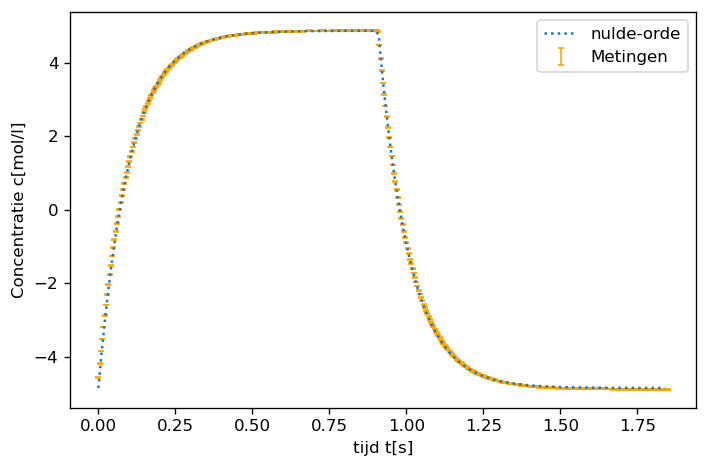

In [194]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(6, 4))
t = np.arange(0, tijd[-1], 0.01)
plt.plot(t, model(t, best_fit_par_0), linestyle=":", label = "nulde-orde", zorder = 100)
ax.set_xlabel("tijd t[s]")
ax.set_ylabel("Concentratie c[mol/l]")
ax.errorbar(tijd, [amplitude[i] for i in range(len(tijd))], yerr = 0.01,color = "orange", label = "Metingen", fmt="None",elinewidth=1, capsize=2)
ax.legend()
plt.tight_layout(); plt.show()

De waarde van tau is 0.10019930540412961
Het 68% onzekerheidsinterval van tau is  0.099883164234 tot 0.100515958184


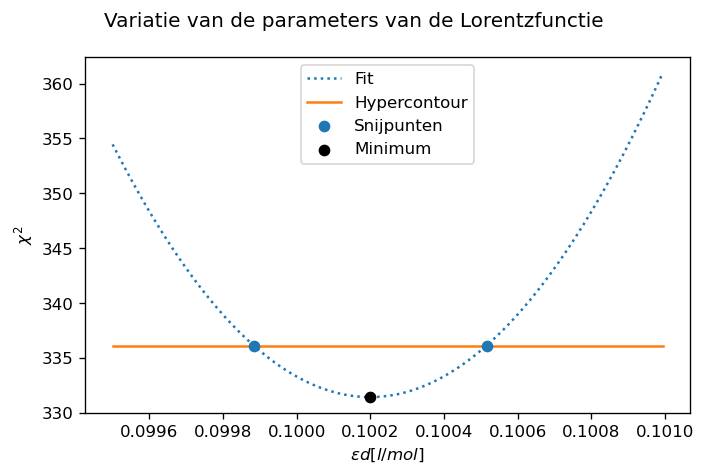

In [199]:
def verschilfunctie(x, par_index, theta, tijd, amplitude):
    theta[par_index] = x
    return chi2(theta, tijd, amplitude, model) - (chi_waarde + sc.stats.chi2.ppf(0.68, df=len(theta)))


def onzekerheids_interval(par_index, theta, tijd, amplitude):
    fout = [sc.optimize.fsolve(verschilfunctie, x0=0.9 * theta[par_index], args = (par_index, theta, tijd, amplitude)), 
            sc.optimize.fsolve(verschilfunctie, x0=1.1*abs(theta[par_index]), args = (par_index, theta, tijd, amplitude))]
    return fout

def absolute_fout(par_index, theta, tijd, amplitude):
    interval = onzekerheids_interval(par_index, theta.copy(), tijd, amplitude)
    return (interval[1] - theta[par_index])[0]

def parameter_plot(ax, plaats, par_index, start, stop, xlabel, tijd, amplitude):
    x = np.arange(start, stop, (stop - start)/250)
    parameters = list(best_fit_par_0.copy())
    parameters[par_index] = x
    if plaats == None:
        ax.plot(x, chi2(parameters, tijd, amplitude, model), linestyle=":", label="Fit")
        ax.plot(x, [chi_waarde + sc.stats.chi2.ppf(0.68, df=len(best_fit_par_0)) for i in range(len(x))], label="Hypercontour")
        fout = onzekerheids_interval(par_index, best_fit_par_0.copy(), tijd, amplitude)
        ax.scatter(fout, [chi_waarde + sc.stats.chi2.ppf(0.68, df=len(best_fit_par_0)), chi_waarde + sc.stats.chi2.ppf(0.68, df=len(best_fit_par_0))], zorder=2, label="Snijpunten")
        ax.scatter(best_fit_par_0[par_index], chi2(best_fit_par_0, tijd, amplitude, model), color="black", zorder=2, label="Minimum")
        ax.set_ylabel(r'$\chi^2$')
        ax.set_xlabel(xlabel)
        ax.legend()
    
    else:
        ax[plaats].plot(x, chi2(parameters, tijd, amplitude, model), linestyle=":", label="Fit")
        ax[plaats].plot(x, [chi_waarde + sc.stats.chi2.ppf(0.68, df=len(best_fit_par_0)) for i in range(len(x))], label="Hypercontour")
        fout = onzekerheids_interval(par_index, best_fit_par_0.copy(), tijd, amplitude)
        ax[plaats].scatter(fout, [chi_waarde + sc.stats.chi2.ppf(0.68, df=len(best_fit_par_0)), chi_waarde + sc.stats.chi2.ppf(0.68, df=len(best_fit_par_0))], zorder=2, label="Snijpunten")
        ax[plaats].scatter(best_fit_par_0[par_index], chi2(best_fit_par_0, tijd, amplitude, model), color="black", zorder=2, label="Minimum")
        ax[plaats].set_ylabel(r'$\chi^2$')
        ax[plaats].set_xlabel(xlabel)
        ax[plaats].legend()
    
def print_onzekerheidsinterval(par_naam: str, par_index, tijd, amplitude):
    fout = onzekerheids_interval(par_index, best_fit_par_0.copy(), tijd, amplitude)
    print("De waarde van " + par_naam + " is", best_fit_par_0[par_index])
    print("Het 68% onzekerheidsinterval van " + par_naam + " is ", round(fout[0][0],12), "tot", round(fout[1][0], 12))
   

chi_waarde = chi2(best_fit_par_0.copy(), tijd, amplitude, model)
print_onzekerheidsinterval("tau", 0, tijd, amplitude)
fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 120, figsize=(6,4))
fig.suptitle("Variatie van de parameters van de Lorentzfunctie")
parameter_plot(ax, None, 0, 0.0995, 0.1010, r'$\epsilon d [l/mol]$', tijd, amplitude)
plt.tight_layout()
plt.show()